# Exercise Number 2
by Orel Ben Israel - ID 205614845

and Maya Glassman - ID 207902966

**Importing Relevant modules**

In [106]:
# Import modules 
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import statsmodels.api as sm  # a module for statistical modelling (e.g. regression analysis)
import io
import warnings
warnings.filterwarnings('ignore')
from PIL import Image,ImageOps
import requests
from io import BytesIO
from numpy import linalg
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pickle, urllib.request


Loading the data:

In [107]:
img = 'https://drive.google.com/file/d/1siJvhUKHQdUMYQ4TdAqvJuARvS2hCo78/view?usp=share_link'
img_url = 'https://drive.google.com/uc?id=' + img.split('/')[-2]

#Question Number 1

## Section A

**Calculating the image's size**

In [108]:
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
width = img.width
height = img.height

print(f'width: {width}\nheight: {height}')

width: 2746
height: 1830


The dimensions of the image are 2746x1830. The dimensions represent the height and width in pixels.

Now we will show the original image

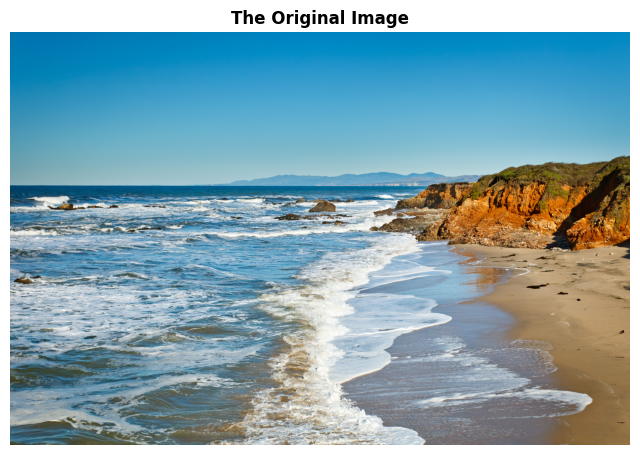

In [109]:
img_arr = np.asarray(img)

plt.figure(figsize=(8,8))
plt.imshow(img_arr)
plt.title('The Original Image', fontweight ="bold")
plt.axis('off')

plt.show()

## Section B

Compute the mean and standard deviation of the color channels of the image array

In [110]:
img_arr = np.asarray(img)
img_arr_sum = img_arr.sum(axis=2)

In [111]:
img_mean = np.mean(img_arr_sum,axis=(0,1))
img_std = np.std(img_arr_sum,axis=(0,1))

Normalize the image array by subtracting the mean and dividing by the standard deviation.

In [112]:
normalized_img_arr = (img_arr_sum - img_mean) / img_std

Convert the normalized image array back to an image using the Image.fromarray() function.

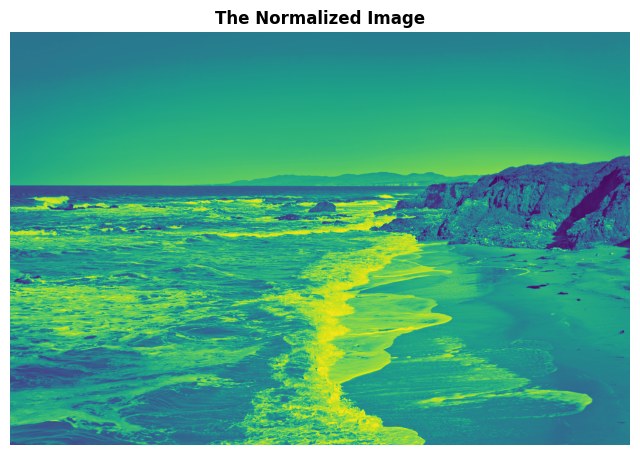

In [113]:
plt.figure(figsize=(8,8))
plt.imshow(normalized_img_arr)
plt.title('The Normalized Image', fontweight ="bold")
plt.axis('off')

plt.show()

The normalization process changed the pixel color values of the image, but not the visual appearance of the image.

## Section C

In [114]:
u, s, vh = np.linalg.svd(normalized_img_arr)

In [115]:
s.shape

(1830,)

The number of singular values is 1830, which is sensible because it is the minimum between the number of the pixles in the width and in the height.

In [116]:
sList = s.tolist()

In [117]:
threshold = 0.01 * max(sList)
greaterValues = [item for item in sList if item > threshold]
print(len(greaterValues))

563


The number of the singular values which grether than the treshold is 563.

In [118]:
indexall = [i for i in range(1, len(sList)+1)]
indexbig = [i for i in range(1, len(greaterValues)+1)]

In [119]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=indexall, y=sList, name = "All Singuar Values", line = dict(color='royalblue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=indexbig, y=greaterValues, name = "Above threshold", line = dict(color='firebrick', width=4, dash='dash')))
fig.update_layout(title='Singular values of the SVD decomposition',
                   xaxis_title='Index',
                   yaxis_title='Singular Value')
fig.show()  

## Section D

In the following section we will rebuild the image using different numbers of PCs.

In [120]:
import sys
bytes_Original = sys.getsizeof(img_arr)
bytes = sys.getsizeof(normalized_img_arr)
print(bytes_Original)
print(bytes)

15075684
40201568


The original image takes 15075684 bytes and the normalized image takes 40201568 bytes.

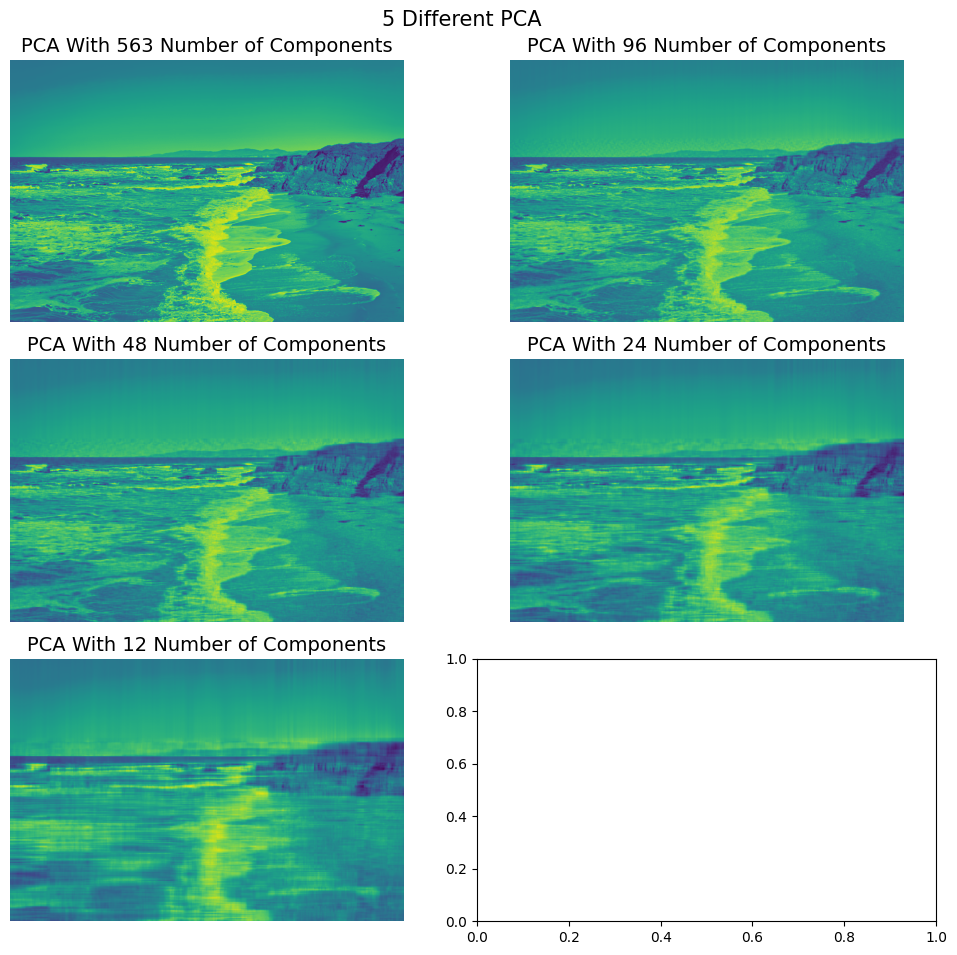

In [121]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(figsize=(10,10), nrows = 3, ncols = 2)
st = fig.suptitle("5 Different PCA", fontsize=15)

components_list = [len(greaterValues), 96, 48, 24, 12]

for i in range(len(components_list)):
    
    row = i // 2
    column = i % 2

    pca = PCA(n_components = components_list[i])
    
    reconstructed_img_arr = u[:, :components_list[i]] @ np.diag(s[:components_list[i]]) @ vh[:components_list[i], :]
    if i==0:
      best_img = reconstructed_img_arr

    ax[row, column].axis('off')
    ax[row, column].set_title("PCA With " + str(components_list[i]) + " Number of Components", fontsize = 14)
    ax[row, column].imshow(reconstructed_img_arr)

plt.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.9)

plt.show()

As expacted, the more principal components we use to recreate the original image, the closer the image is to its origin.

In [122]:
import os

dataImg = Image.fromarray(best_img.astype(np.uint8))
      
# saving the final output as a jpg file
dataImg.save('BestImgFinal.jpg')

In [123]:
PCA563size = os.path.getsize("/content/BestImgFinal.jpg")
PCA563size

728012

After recreating the image with 563 components we get a smaller file size (this image takes 728012 bytes), however the quality of the image is not impacted dramatically - at least not in a way that is visible to the human eye (which is great!).

#Question Number 2

## Section A

In [124]:
features = 'https://drive.google.com/file/d/1I4Qly1AuLLBAHLFj5wukxJHGexZZLaTf/view?usp=share_link'
features_url = 'https://drive.google.com/uc?id=' + features.split('/')[-2]
features = np.loadtxt(features_url, dtype="str", delimiter="\t")

exodus = 'https://drive.google.com/file/d/1qmYXEtnLwrSQqZHETB9G-q_auJy5KuTO/view?usp=share_link'
exodus_url = 'https://drive.google.com/uc?id=' + exodus.split('/')[-2]

labels_u = pd.read_csv("labels.txt", names = ['labels'])
exodus = pickle.load(urllib.request.urlopen('https://storage.googleapis.com/statistical-learning/exodus_pickled'))


In [125]:
exodus.shape

(1201, 15373)

The dimension in the exodus matrix that relates to the features and labels matrices is the column dimention. Whenever a combination of three words appear in the sentence, the matching cell in the matrix will appear as '1'. The dimension is 15373.

## Section B

In its current form, it would be impossible to classify the sentences into groups by creating a plot for the data in the matrix, since the data isof a high dimension. Therefore, we would like to reduce the dimension by performing PCA, as learnt in class.

## Section C

In [126]:
u, s, vh = np.linalg.svd(exodus) # performing the SVD decomposition

In [127]:
s.shape

(1201,)

The dimension of s is 1201 X 1

In [128]:
u.shape

(1201, 1201)

The dimension of u is 1201 X 1201

In [129]:
vh.shape

(15373, 15373)

vh is of dimension 15,373 X 15,373, meaning the dimension of the features = number of word combinations in the book. For this reason, is represents the contribution of every feature (combination of 3 words) in the data, to the explained variance of the different PCs, where the **every row represents a pc** and every column represents the contribution to the variance of the projected data points to the pc.

## Section D

In [130]:
# extract the first row
first_pc = vh[0,:]

# find the indices of the 10 largest absolute values in the row
largest_indices = np.argsort(np.abs(first_pc))[::-1][0,-10:]
matching_values = features[largest_indices]
for word in matching_values:
  print(word)


["('תכלת', 'ו', 'ארגמן')" "('ו', 'עשׂה', 'ל')" "('צפה', 'את', 'זהב')"
 "('ה', 'אחד', 'ו')" "('ו', 'נתן', 'את')" "('אמה', 'ו', 'חצי')"
 "('ו', 'את', 'ה')" "('ו', 'צפה', 'את')" "('עשׂה', 'את', 'ה')"
 "('ו', 'עשׂה', 'את')"]


Amongst the 10 top contributing combinations to the distribution of the projected points on the first PC, there is a repetition of conjunctions and link words such as "and", "to", and "the". In addition, the word "god" repeats.

Moreover, It is worth pointing out that some of the combinations of 3 words may catually come from 4 word combinations. For example, 

* ו צפה את

* צפה את זהב

Are likely to have come from the same sentences.

The importance of these combinations suggest that they appear in a variety of sentances, but not in all of the sentences and not even in the majority of the sentances. This is becaue if a combination of words appear in most of the sentences or in almost none of the sentences, it will be less likely to contribute to the distribution. In addition, It suggests that it may be common that they appear together often.

## Section E

From a search of the most contributing 3-word combinations in the hebrew website "Bible Search" it appears that most of them appear in the book exodus chapters 25-37. These chapters describe the creation of the holy covenant and the tabernacle as directed by god. This approves our theory that the word-combinations appear closely in the sentences.

Let's remember that these are the combinations that are mostly responsible to the distribution of the data projected on the first PC, which is the PC the has the largest distribution in the first place.

From these results we can see that these chapters can be seperated in some way from the other chapters in exodus. Perhaps we can theorise that they could have been written by a different author than that of the rest of exodus.

## Section F

In order to project the sentences on the 2 first PCs we will perform a skalar multiplication between the exodus matrix and the first 2 rows of vh, which represent the contribution of each of the features to the distribution of the projected points on these PCs.

The result of this multiplication will be a 1201 X 2 dimentional matrix, where every row represents a sentence and every colomn represents the value of the projection of the sentence on one of the 2 PCs. In this way we get 2-dimensional data which we can present in a plot.

In [131]:
data_2_dim = exodus@vh[:2,:].T
data_2_dim.shape
data_2_dim=pd.DataFrame(data_2_dim, columns = ["pc1", "pc2"])
data_2_dim = data_2_dim.join(labels_u['labels'])

In [132]:
fig = px.scatter(data_2_dim, x="pc1", y="pc2", title = "Projection of sentences in Exodus on the first 2 PCs", color='labels')
fig.show()

The hypothatical seperation to the two groups by the labels is in accordance with the seperation created by the projection of the points onto the plane that is created by the two PCs. However, the seperation in not perfect - it can be seen that come yellow points which are labeled '1' appear close the the blue points that are labeled '0'.

The fact that the PCA shows the same seperation as the labels, implies that there is a connection between the use of different combinations of words in a chapter, and the auther of the chapter.

## Section G

In the above research, we tried to examine whether there is a connection between the identity of the writer of a biblical chapter in the book Exodus, and his use of language. The assumption of the statistical research was that different writers would use different expressions.

In order to test this assumption, we used several databases:
1. Exodus - a matrix that represents the mathematical coding of the text in the book of Exodus: the row space represents the sentences and the column space represents the space of our explanatory variables - each value in a vector represents three consecutive words that appear one after the other in sequence, which exists in the book. The numerical value of each entry in the vector represents whether that particular combination is present in that particular sentence (1) or not (0).
2. Features - Indicates which three words each column is associated with.
3. Labels - Contains a hypothetical association of each sentence to one
of two groups: 0, or 1 (Cohen or not). We used this database in order to validate our reasearch assumption.

In order to test and verify the research question, we performed SVD decomposition on the "exodus" data. This decomposition created three sub-matrices that helped us carry out the PCA process. It then reduced the dimension of the explanatory variables from the number of 3-word combinations present in the book of Exodus to only two dimensions.

For the benefit of this process we used the matrix vh, the rows of which represent the contribution of each of the features to the distribution of the projected points on the different PCs. The PCs are the new axises which contribute the most to the distribution of the data. 

By taking the first two rows of matrix vh, and multiplying them by the exodus matrix, we were able to plot the data using the two axises that contribute the most to the distribution of the data. This helped us seperate the data into two groups, which as seen, was correleted with the labels, therefore approving our research assumption.

Another statistical tool that is worth examination is logistic regression, which can use the same matrix "exodus" in order to label the sentences as "0" or "1".